In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import requests
import torch
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
import glob

# Set the working directory
os.chdir('/Users/robertds413/Documents/Flag_Predictor')
print(f"Working directory: {os.getcwd()}")


Working directory: /Users/robertds413/Documents/Flag_Predictor


In [2]:
def process_lock_api_data(data):
    """Process API data from flood monitoring service"""
    if 'items' not in data or not data['items']:
        return pd.DataFrame()
    
    temp_df = pd.DataFrame(data['items'])
    if 'dateTime' not in temp_df.columns or 'value' not in temp_df.columns:
        return pd.DataFrame()
    
    temp_df = temp_df[['dateTime', 'value']]
    temp_df.rename(columns={'dateTime': 'timestamp', 'value': 'level'}, inplace=True)
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
    df = temp_df.set_index('timestamp')
    return df

def process_rainfall_api_data(data):
    """Process rainfall API data from flood monitoring service"""
    if 'items' not in data or not data['items']:
        return pd.DataFrame()
    
    temp_df = pd.DataFrame(data['items'])
    if 'dateTime' not in temp_df.columns or 'value' not in temp_df.columns:
        return pd.DataFrame()
    
    temp_df = temp_df[['dateTime', 'value']]
    temp_df.rename(columns={'dateTime': 'timestamp', 'value': 'rainfall'}, inplace=True)
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
    df = temp_df.set_index('timestamp')
    return df



# API URLs
kings_mill_downstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1491TH-level-downstage-i-15_min-mASD/readings?_sorted&_limit=90000'
godstow_downstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1302TH-level-downstage-i-15_min-mASD/readings?_sorted&_limit=90000'
osney_upstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1303TH-level-stage-i-15_min-mASD/readings?_sorted&_limit=90000'
osney_downstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1303TH-level-downstage-i-15_min-mASD/readings?_sorted&_limit=90000'
iffley_upstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1501TH-level-stage-i-15_min-mASD/readings?_sorted&_limit=90000'

# Rainfall API URLs
rainfall_urls = [
    'http://environment.data.gov.uk/flood-monitoring/id/measures/256230TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/254336TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/251530TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/248332TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/248965TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/251556TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/253340TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/254829TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/257039TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/259110TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/256345TPrainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/249744TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/253861TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000'
]

location_names = ['Osney', 'Eynsham', 'St', 'Shorncote', 'Rapsgate', 'Stowell', 
                  'Bourton', 'Chipping', 'Grimsbury', 'Bicester', 'Byfield', 'Swindon', 'Worsham']

print("Fetching river level data...")
# Get river level data
kings_mill_downstream_df = process_lock_api_data(requests.get(kings_mill_downstream_url).json())
godstow_downstream_df = process_lock_api_data(requests.get(godstow_downstream_url).json())
osney_upstream_df = process_lock_api_data(requests.get(osney_upstream_url).json())
osney_downstream_df = process_lock_api_data(requests.get(osney_downstream_url).json())
iffley_upstream_df = process_lock_api_data(requests.get(iffley_upstream_url).json())

print("Fetching rainfall data...")
# Get rainfall data
rainfall_api_dfs = {}
for url, name in zip(rainfall_urls, location_names):
    response = requests.get(url)
    data = response.json()
    df = process_rainfall_api_data(data)
    if not df.empty:
        df.rename(columns={'rainfall': name}, inplace=True)
        rainfall_api_dfs[name] = df

# Combine all rainfall API datasets
mega_rainfall_api_df = pd.concat(rainfall_api_dfs.values(), axis=1)
print(f"\n✓ Combined rainfall API data: {mega_rainfall_api_df.shape}")
print(f"Date range: {mega_rainfall_api_df.index.min()} to {mega_rainfall_api_df.index.max()}")


Fetching river level data...
Fetching rainfall data...

✓ Combined rainfall API data: (2824, 12)
Date range: 2025-11-07 00:00:00+00:00 to 2025-12-06 14:30:00+00:00


In [42]:
# Calculate isis and godstow differential
isis_diff_isis_contrib = 0.71 * (osney_downstream_df['level'] - iffley_upstream_df['level'] - 2.14)
isis_diff_cherwell_contrib = 0.29 * (kings_mill_downstream_df['level'] - iffley_upstream_df['level'] - 0.73)
isis_differential_api = isis_diff_isis_contrib + isis_diff_cherwell_contrib

godstow_differential_api = godstow_downstream_df['level'] - osney_upstream_df['level'] - 1.63

# Convert to DataFrames
isis_api_diff_df = pd.DataFrame({'differential': isis_differential_api})
godstow_api_diff_df = pd.DataFrame({'differential': godstow_differential_api})

print(f"✓ ISIS differential API data: {isis_api_diff_df.shape}")
print(f"✓ Godstow differential API data: {godstow_api_diff_df.shape}")


✓ ISIS differential API data: (2755, 1)
✓ Godstow differential API data: (2754, 1)


In [43]:
# Kalman Filter Implementation for Differential Estimation
class SimpleKalmanFilter:
    """
    Simple 1D Kalman Filter for estimating true differential from noisy measurements.
    
    The filter tracks:
    - State (x): the true differential value
    - Covariance (P): uncertainty in the state estimate
    - Process noise (Q): how much the state can change over time
    - Measurement noise (R): noise in observations
    """
    
    def __init__(self, initial_state=0.0, initial_covariance=1.0, 
                 process_noise=0.01, measurement_noise=0.1):
        """
        Initialize the Kalman filter.
        
        Parameters:
        -----------
        initial_state : float
            Initial estimate of the state (differential value)
        initial_covariance : float
            Initial uncertainty in the state estimate
        process_noise : float
            Process noise covariance (Q) - how much the state can change
        measurement_noise : float
            Measurement noise covariance (R) - noise in observations
        """
        self.x = initial_state  # State estimate
        self.P = initial_covariance  # State covariance (uncertainty)
        self.Q = process_noise  # Process noise
        self.R = measurement_noise  # Measurement noise
        
        # Store history for analysis
        self.state_history = []
        self.covariance_history = []
        self.measurement_history = []
        self.kalman_gain_history = []
    
    def predict(self):
        """Predict step: update state estimate based on process model."""
        # Simple constant velocity model (state doesn't change in prediction)
        # In practice, this means we predict the state stays the same
        # but uncertainty increases due to process noise
        self.P += self.Q
        return self.x, self.P
    
    def update(self, measurement):
        """
        Update step: incorporate new measurement.
        
        Parameters:
        -----------
        measurement : float
            New observed differential value
            
        Returns:
        --------
        float
            Updated state estimate (filtered differential)
        float
            Updated covariance (uncertainty)
        """
        # Store measurement
        self.measurement_history.append(measurement)
        
        # Prediction step
        self.predict()
        
        # Calculate Kalman gain
        K = self.P / (self.P + self.R)
        self.kalman_gain_history.append(K)
        
        # Update state estimate
        self.x = self.x + K * (measurement - self.x)
        
        # Update covariance
        self.P = (1 - K) * self.P
        
        # Store history
        self.state_history.append(self.x)
        self.covariance_history.append(self.P)
        
        return self.x, self.P
    
    def filter(self, measurements):
        """
        Apply Kalman filter to a sequence of measurements.
        
        Parameters:
        -----------
        measurements : array-like
            Sequence of differential measurements
            
        Returns:
        --------
        numpy.ndarray
            Filtered state estimates
        numpy.ndarray
            Covariance history
        """
        filtered = []
        for measurement in measurements:
            state, cov = self.update(measurement)
            filtered.append(state)
        
        return np.array(filtered), np.array(self.covariance_history)
    
    def reset(self, initial_state=None, initial_covariance=None):
        """Reset filter to initial state."""
        if initial_state is not None:
            self.x = initial_state
        if initial_covariance is not None:
            self.P = initial_covariance
        
        self.state_history = []
        self.covariance_history = []
        self.measurement_history = []
        self.kalman_gain_history = []

print("✓ Kalman Filter class defined")


✓ Kalman Filter class defined


In [45]:
# Prepare differential data for Kalman filtering
print("Preparing differential data...")

# Remove any NaN values and sort by timestamp
isis_api_diff_df_clean = isis_api_diff_df.dropna().sort_index()
godstow_api_diff_df_clean = godstow_api_diff_df.dropna().sort_index()

print(f"✓ ISIS differential: {len(isis_api_diff_df_clean)} measurements")
print(f"  Date range: {isis_api_diff_df_clean.index.min()} to {isis_api_diff_df_clean.index.max()}")
print(f"✓ Godstow differential: {len(godstow_api_diff_df_clean)} measurements")
print(f"  Date range: {godstow_api_diff_df_clean.index.min()} to {godstow_api_diff_df_clean.index.max()}")

# Extract measurement values
isis_measurements = isis_api_diff_df_clean['differential'].values
godstow_measurements = godstow_api_diff_df_clean['differential'].values

# Estimate noise parameters from data
isis_measurement_noise = np.std(np.diff(isis_measurements)) if len(isis_measurements) > 1 else 0.1
godstow_measurement_noise = np.std(np.diff(godstow_measurements)) if len(godstow_measurements) > 1 else 0.1

print(f"\nEstimated noise parameters:")
print(f"  ISIS measurement noise: {isis_measurement_noise:.4f}")
print(f"  Godstow measurement noise: {godstow_measurement_noise:.4f}")


Preparing differential data...
✓ ISIS differential: 2675 measurements
  Date range: 2025-11-07 00:00:00+00:00 to 2025-12-05 20:45:00+00:00
✓ Godstow differential: 2753 measurements
  Date range: 2025-11-07 00:00:00+00:00 to 2025-12-06 14:30:00+00:00

Estimated noise parameters:
  ISIS measurement noise: 0.0110
  Godstow measurement noise: 0.0116


In [6]:
# ============================================================================
# KALMAN FILTER PARAMETERS - ADJUST THESE FOR MORE/LESS SMOOTHING
# ============================================================================
# Key Parameters:
#   1. measurement_noise (R): How noisy are the measurements?
#      - LARGER values = MORE smoothing (filter trusts measurements less)
#      - Try: 0.1, 0.5, 1.0, or 2.0 for more smoothing
#      - Current: auto-estimated from data (~0.011)
#
#   2. process_noise (Q): How much can the true value change?
#      - SMALLER values = MORE smoothing (filter thinks state changes slowly)
#      - Try: 0.001, 0.0001, or 0.00001 for more smoothing
#      - Current: 0.01
#
# For MORE smoothing: Increase measurement_noise and/or decrease process_noise
# ============================================================================

# ADJUST THESE VALUES:
PROCESS_NOISE = 0.01        # Lower = more smoothing (try 0.001 or 0.0001)
MEASUREMENT_NOISE_FACTOR = 1.0  # Multiplier for measurement noise (try 5.0, 10.0, 20.0 for more smoothing)

# Calculate adjusted measurement noise
isis_adj_measurement_noise = isis_measurement_noise * MEASUREMENT_NOISE_FACTOR
godstow_adj_measurement_noise = godstow_measurement_noise * MEASUREMENT_NOISE_FACTOR

print("Applying Kalman filters...\n")
print(f"Filter Parameters:")
print(f"  Process Noise (Q): {PROCESS_NOISE}")
print(f"  ISIS Measurement Noise (R): {isis_adj_measurement_noise:.4f} (factor: {MEASUREMENT_NOISE_FACTOR}x)")
print(f"  Godstow Measurement Noise (R): {godstow_adj_measurement_noise:.4f} (factor: {MEASUREMENT_NOISE_FACTOR}x)")
print()

# Initialize Kalman filters
# Use first measurement as initial state estimate
isis_kf = SimpleKalmanFilter(
    initial_state=isis_measurements[0] if len(isis_measurements) > 0 else 0.0,
    initial_covariance=1.0,
    process_noise=PROCESS_NOISE,
    measurement_noise=isis_adj_measurement_noise
)

godstow_kf = SimpleKalmanFilter(
    initial_state=godstow_measurements[0] if len(godstow_measurements) > 0 else 0.0,
    initial_covariance=1.0,
    process_noise=PROCESS_NOISE,
    measurement_noise=godstow_adj_measurement_noise
)

# Apply filters
isis_filtered, isis_covariance = isis_kf.filter(isis_measurements)
godstow_filtered, godstow_covariance = godstow_kf.filter(godstow_measurements)

# Create DataFrames with filtered results
isis_filtered_df = pd.DataFrame({
    'raw_differential': isis_measurements,
    'filtered_differential': isis_filtered,
    'uncertainty': np.sqrt(isis_covariance)
}, index=isis_api_diff_df_clean.index)

godstow_filtered_df = pd.DataFrame({
    'raw_differential': godstow_measurements,
    'filtered_differential': godstow_filtered,
    'uncertainty': np.sqrt(godstow_covariance)
}, index=godstow_api_diff_df_clean.index)

print("✓ Kalman filtering complete")
print(f"\nISIS Filter Results:")
print(f"  Mean raw differential: {isis_measurements.mean():.4f}")
print(f"  Mean filtered differential: {isis_filtered.mean():.4f}")
print(f"  Mean uncertainty: {np.sqrt(isis_covariance).mean():.4f}")

print(f"\nGodstow Filter Results:")
print(f"  Mean raw differential: {godstow_measurements.mean():.4f}")
print(f"  Mean filtered differential: {godstow_filtered.mean():.4f}")
print(f"  Mean uncertainty: {np.sqrt(godstow_covariance).mean():.4f}")


Applying Kalman filters...

Filter Parameters:
  Process Noise (Q): 0.01
  ISIS Measurement Noise (R): 0.0110 (factor: 1.0x)
  Godstow Measurement Noise (R): 0.0116 (factor: 1.0x)

✓ Kalman filtering complete

ISIS Filter Results:
  Mean raw differential: 0.1562
  Mean filtered differential: 0.1561
  Mean uncertainty: 0.0814

Godstow Filter Results:
  Mean raw differential: 0.3444
  Mean filtered differential: 0.3442
  Mean uncertainty: 0.0830


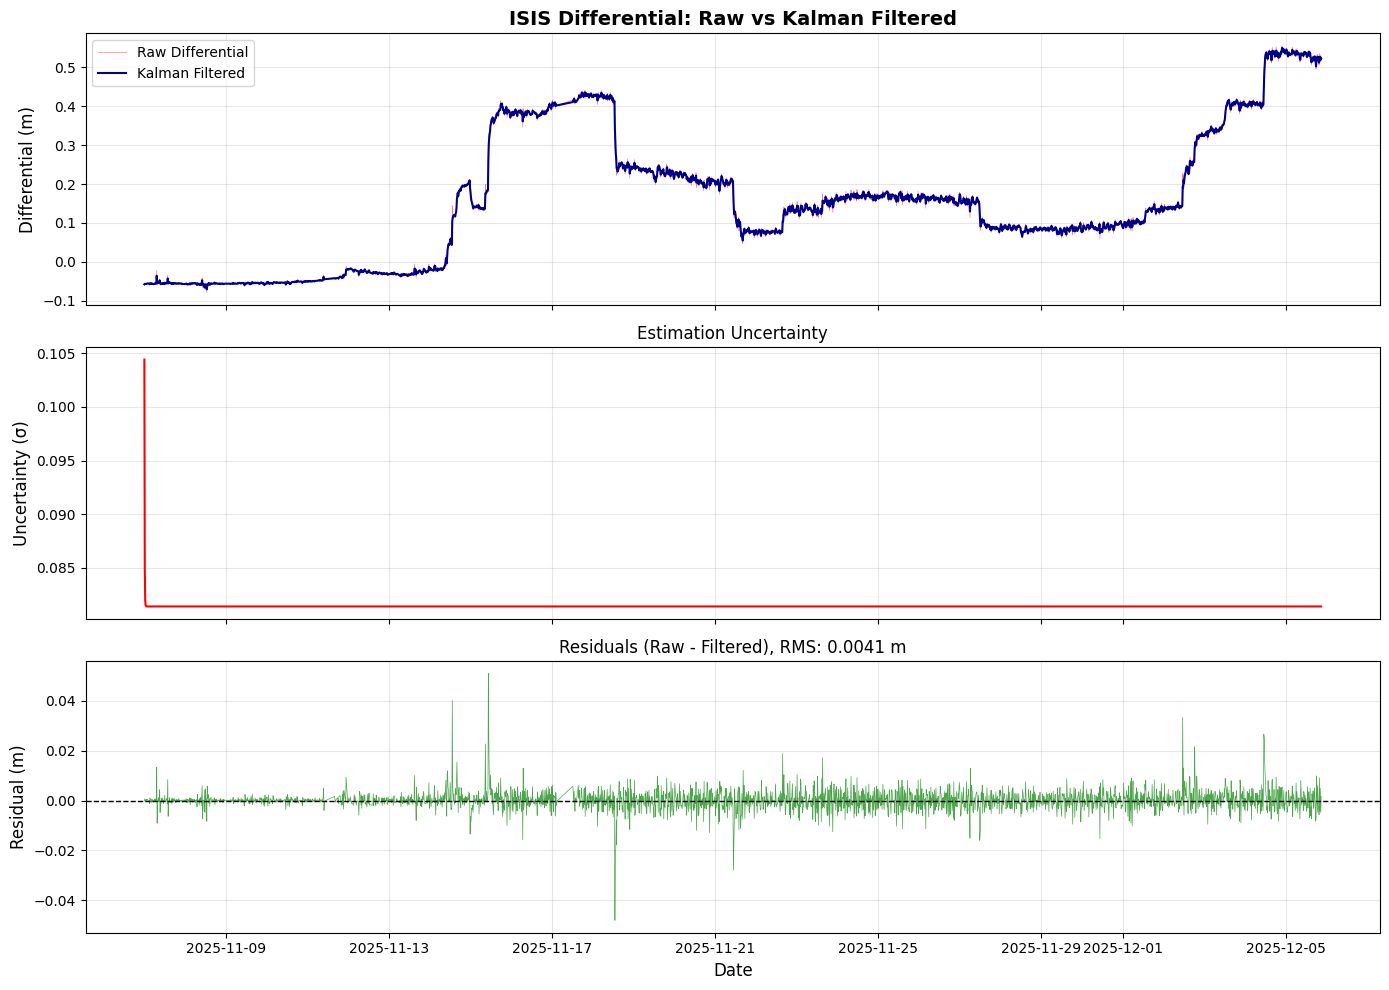

In [7]:
# Visualize Kalman filter results for ISIS differential
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Raw vs Filtered differential
axes[0].plot(isis_filtered_df.index, isis_filtered_df['raw_differential'], 
             alpha=0.5, label='Raw Differential', linewidth=0.5, color='red')
axes[0].plot(isis_filtered_df.index, isis_filtered_df['filtered_differential'], 
             label='Kalman Filtered', linewidth=1.5, color='darkblue')
axes[0].set_ylabel('Differential (m)', fontsize=12)
axes[0].set_title('ISIS Differential: Raw vs Kalman Filtered', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Uncertainty
axes[1].plot(isis_filtered_df.index, isis_filtered_df['uncertainty'], 
             color='red', linewidth=1.5)
axes[1].set_ylabel('Uncertainty (σ)', fontsize=12)
axes[1].set_title('Estimation Uncertainty', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Plot 3: Residuals (raw - filtered)
residuals_isis = isis_filtered_df['raw_differential'] - isis_filtered_df['filtered_differential']
axes[2].plot(isis_filtered_df.index, residuals_isis, 
             color='green', linewidth=0.5, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_ylabel('Residual (m)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_title(f'Residuals (Raw - Filtered), RMS: {np.sqrt(np.mean(residuals_isis**2)):.4f} m', 
                  fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


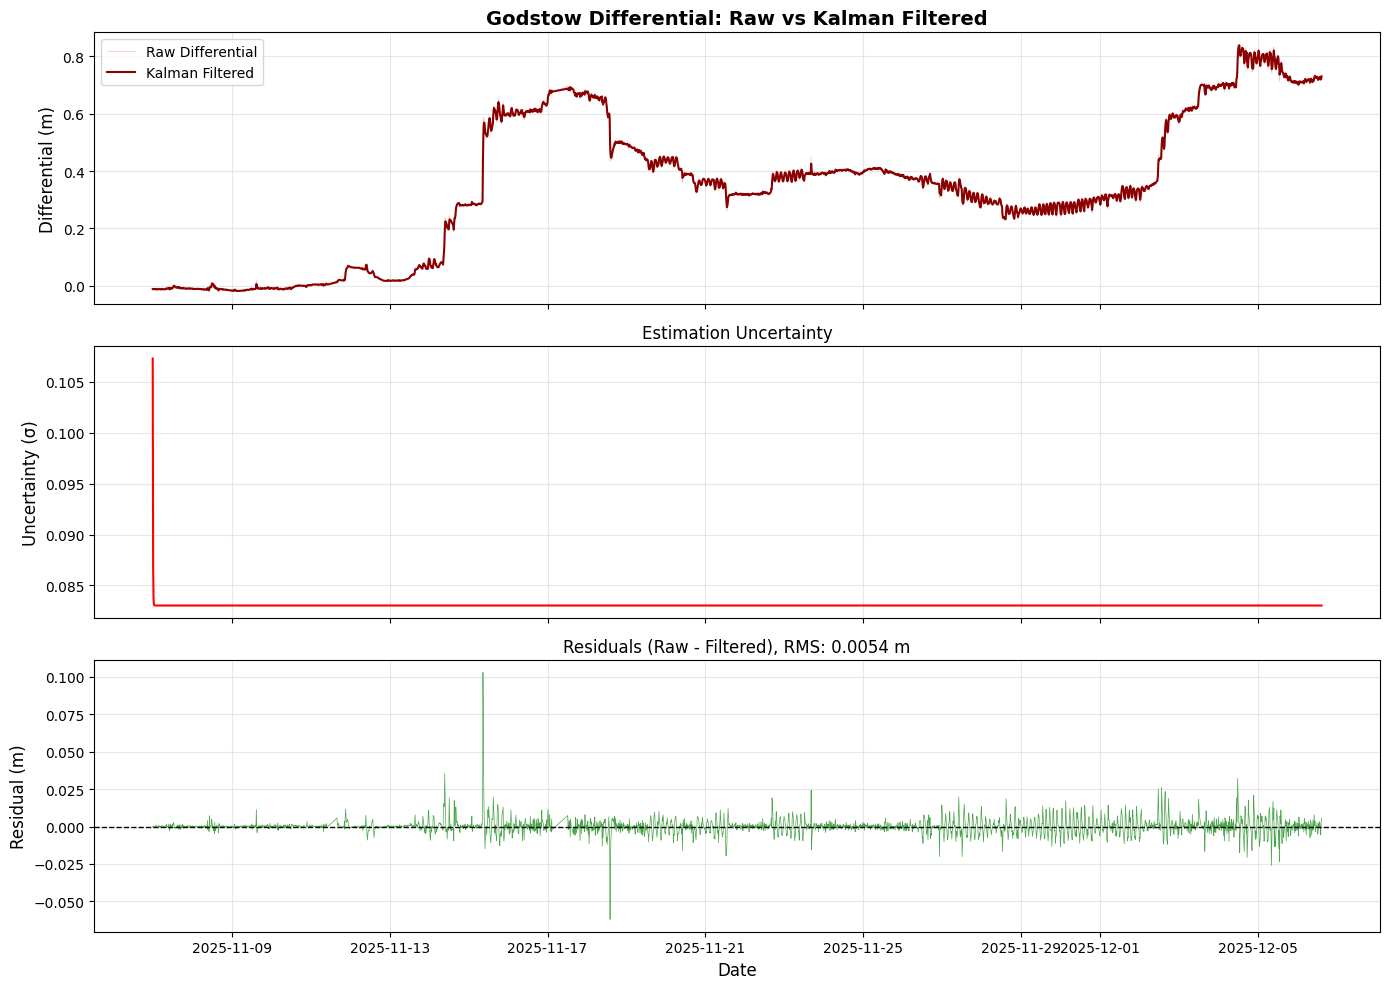

In [8]:
# Visualize Kalman filter results for Godstow differential
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Raw vs Filtered differential
axes[0].plot(godstow_filtered_df.index, godstow_filtered_df['raw_differential'], 
             alpha=0.5, label='Raw Differential', linewidth=0.5, color='lightcoral')
axes[0].plot(godstow_filtered_df.index, godstow_filtered_df['filtered_differential'], 
             label='Kalman Filtered', linewidth=1.5, color='darkred')
axes[0].set_ylabel('Differential (m)', fontsize=12)
axes[0].set_title('Godstow Differential: Raw vs Kalman Filtered', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Uncertainty
axes[1].plot(godstow_filtered_df.index, godstow_filtered_df['uncertainty'], 
             color='red', linewidth=1.5)
axes[1].set_ylabel('Uncertainty (σ)', fontsize=12)
axes[1].set_title('Estimation Uncertainty', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Plot 3: Residuals (raw - filtered)
residuals_godstow = godstow_filtered_df['raw_differential'] - godstow_filtered_df['filtered_differential']
axes[2].plot(godstow_filtered_df.index, residuals_godstow, 
             color='green', linewidth=0.5, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_ylabel('Residual (m)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_title(f'Residuals (Raw - Filtered), RMS: {np.sqrt(np.mean(residuals_godstow**2)):.4f} m', 
                  fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


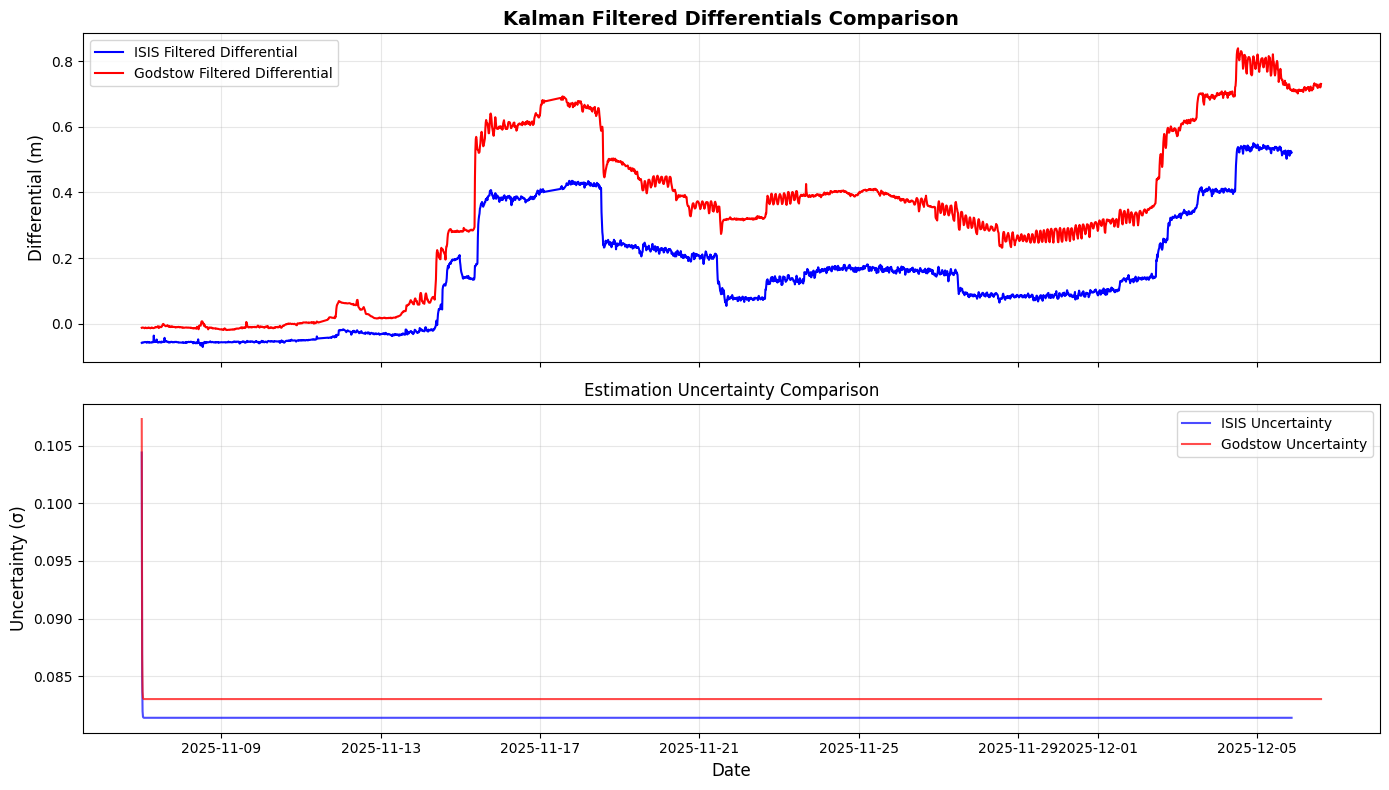

In [9]:
# Compare both filtered differentials
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot both filtered differentials
axes[0].plot(isis_filtered_df.index, isis_filtered_df['filtered_differential'], 
             label='ISIS Filtered Differential', linewidth=1.5, color='blue')
axes[0].plot(godstow_filtered_df.index, godstow_filtered_df['filtered_differential'], 
             label='Godstow Filtered Differential', linewidth=1.5, color='red')
axes[0].set_ylabel('Differential (m)', fontsize=12)
axes[0].set_title('Kalman Filtered Differentials Comparison', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot uncertainties
axes[1].plot(isis_filtered_df.index, isis_filtered_df['uncertainty'], 
             label='ISIS Uncertainty', linewidth=1.5, color='blue', alpha=0.7)
axes[1].plot(godstow_filtered_df.index, godstow_filtered_df['uncertainty'], 
             label='Godstow Uncertainty', linewidth=1.5, color='red', alpha=0.7)
axes[1].set_ylabel('Uncertainty (σ)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_title('Estimation Uncertainty Comparison', fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Statistical summary
print("="*70)
print("KALMAN FILTER SUMMARY STATISTICS")
print("="*70)

print("\nISIS Differential:")
print(f"  Raw Measurements:")
print(f"    Count: {len(isis_measurements)}")
print(f"    Mean: {isis_measurements.mean():.4f} m")
print(f"    Std: {isis_measurements.std():.4f} m")
print(f"    Min: {isis_measurements.min():.4f} m")
print(f"    Max: {isis_measurements.max():.4f} m")
print(f"  Filtered Estimates:")
print(f"    Mean: {isis_filtered.mean():.4f} m")
print(f"    Std: {isis_filtered.std():.4f} m")
print(f"    Mean Uncertainty: {np.sqrt(isis_covariance).mean():.4f} m")
print(f"    Noise Reduction: {(1 - isis_filtered.std() / isis_measurements.std()) * 100:.2f}%")

print("\nGodstow Differential:")
print(f"  Raw Measurements:")
print(f"    Count: {len(godstow_measurements)}")
print(f"    Mean: {godstow_measurements.mean():.4f} m")
print(f"    Std: {godstow_measurements.std():.4f} m")
print(f"    Min: {godstow_measurements.min():.4f} m")
print(f"    Max: {godstow_measurements.max():.4f} m")
print(f"  Filtered Estimates:")
print(f"    Mean: {godstow_filtered.mean():.4f} m")
print(f"    Std: {godstow_filtered.std():.4f} m")
print(f"    Mean Uncertainty: {np.sqrt(godstow_covariance).mean():.4f} m")
print(f"    Noise Reduction: {(1 - godstow_filtered.std() / godstow_measurements.std()) * 100:.2f}%")

print("\n" + "="*70)


KALMAN FILTER SUMMARY STATISTICS

ISIS Differential:
  Raw Measurements:
    Count: 2675
    Mean: 0.1562 m
    Std: 0.1657 m
    Min: -0.0790 m
    Max: 0.5555 m
  Filtered Estimates:
    Mean: 0.1561 m
    Std: 0.1655 m
    Mean Uncertainty: 0.0814 m
    Noise Reduction: 0.12%

Godstow Differential:
  Raw Measurements:
    Count: 2753
    Mean: 0.3444 m
    Std: 0.2369 m
    Min: -0.0210 m
    Max: 0.8410 m
  Filtered Estimates:
    Mean: 0.3442 m
    Std: 0.2368 m
    Mean Uncertainty: 0.0830 m
    Noise Reduction: 0.07%



# Kalman Filter Parameters Guide

## Understanding the Parameters

The Kalman filter has two main tuning parameters that control smoothing:

### 1. **Measurement Noise (R)** - How unreliable are the measurements?
- **What it does**: Tells the filter how much noise is in each observation
- **For MORE smoothing**: **INCREASE** this value
  - Larger R → Filter trusts measurements less → More smoothing
  - Try: 0.1, 0.5, 1.0, 2.0, or 5.0
- **For LESS smoothing**: **DECREASE** this value
  - Smaller R → Filter trusts measurements more → Less smoothing

### 2. **Process Noise (Q)** - How quickly can the true value change?
- **What it does**: Tells the filter how much the underlying true value can vary
- **For MORE smoothing**: **DECREASE** this value
  - Smaller Q → Filter thinks state changes slowly → More smoothing
  - Try: 0.001, 0.0001, or 0.00001
- **For LESS smoothing**: **INCREASE** this value
  - Larger Q → Filter adapts faster → Less smoothing

## Quick Tips for More Smoothing

**Option 1**: Increase measurement noise factor to 10-50x (e.g., `MEASUREMENT_NOISE_FACTOR = 20.0`)

**Option 2**: Decrease process noise significantly (e.g., `PROCESS_NOISE = 0.001` or `0.0001`)

**Option 3**: Do both for maximum smoothing

## How the Kalman Gain Works

The filter uses **Kalman Gain (K)** to decide how much to trust new measurements:
- K = P / (P + R)
- Small K (< 0.1) = More smoothing (trusts previous estimate more)
- Large K (> 0.9) = Less smoothing (trusts new measurements more)

By adjusting R and Q, you control K indirectly.


In [48]:
# Compare different smoothing levels (optional - uncomment to run)
# This shows the effect of different parameter settings

def apply_kalman_with_params(measurements, process_noise, measurement_noise, initial_state):
    """Helper function to apply Kalman filter with specific parameters"""
    kf = SimpleKalmanFilter(
        initial_state=initial_state,
        initial_covariance=1.0,
        process_noise=process_noise,
        measurement_noise=measurement_noise
    )
    filtered, _ = kf.filter(measurements)
    return filtered

# Define different smoothing levels to compare
smoothing_configs = {
    'Low Smoothing': {'Q': 0.1, 'R_factor': 0.5},
    'Medium Smoothing (Current)': {'Q': 0.05, 'R_factor': 10.0},
    'High Smoothing': {'Q': 0.001, 'R_factor': 10.0},
    'Very High Smoothing': {'Q': 0.0001, 'R_factor': 50.0}
}

print("Comparing different smoothing levels...")
print("="*70)

# Apply filters with different settings for Godstow
godstow_comparison = {}
for name, config in smoothing_configs.items():
    r_noise = godstow_measurement_noise * config['R_factor']
    filtered = apply_kalman_with_params(
        godstow_measurements, 
        config['Q'], 
        r_noise,
        godstow_measurements[0]
    )
    godstow_comparison[name] = filtered
    std_reduction = (1 - filtered.std() / godstow_measurements.std()) * 100
    print(f"{name:25s} | Q={config['Q']:8.5f}, R_factor={config['R_factor']:5.1f} | Std Reduction: {std_reduction:5.2f}%")

print("\n" + "="*70)


Comparing different smoothing levels...
Low Smoothing             | Q= 0.10000, R_factor=  0.5 | Std Reduction:  0.01%
Medium Smoothing (Current) | Q= 0.05000, R_factor= 10.0 | Std Reduction:  0.10%
High Smoothing            | Q= 0.00100, R_factor= 10.0 | Std Reduction:  0.52%
Very High Smoothing       | Q= 0.00010, R_factor= 50.0 | Std Reduction:  5.74%



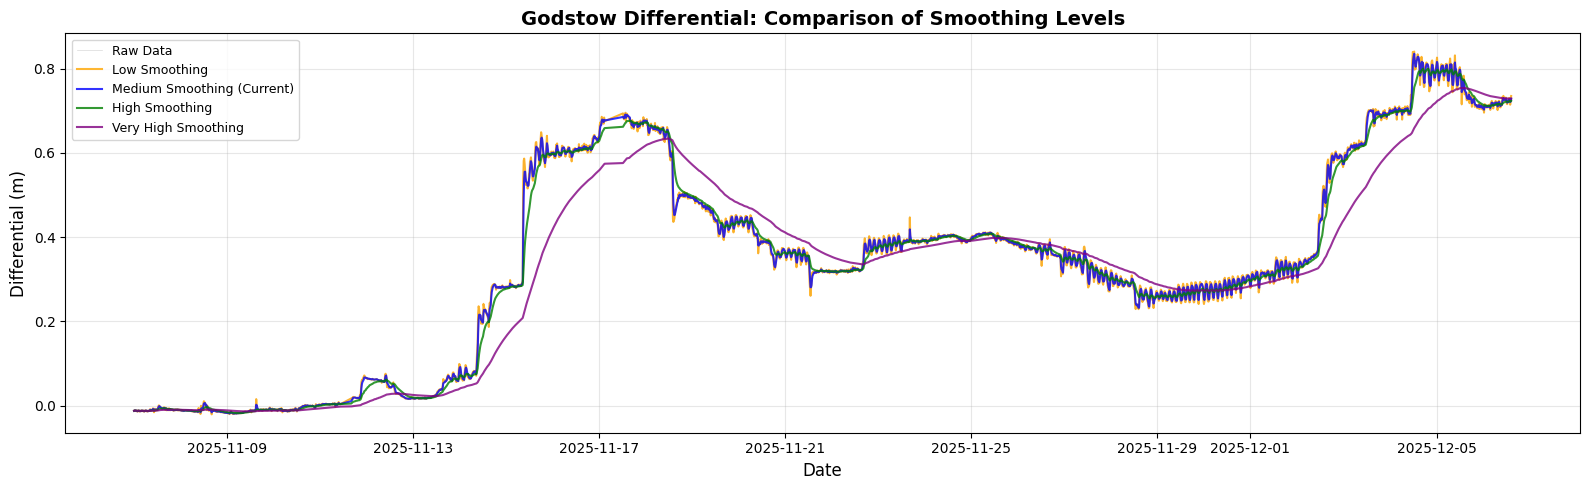

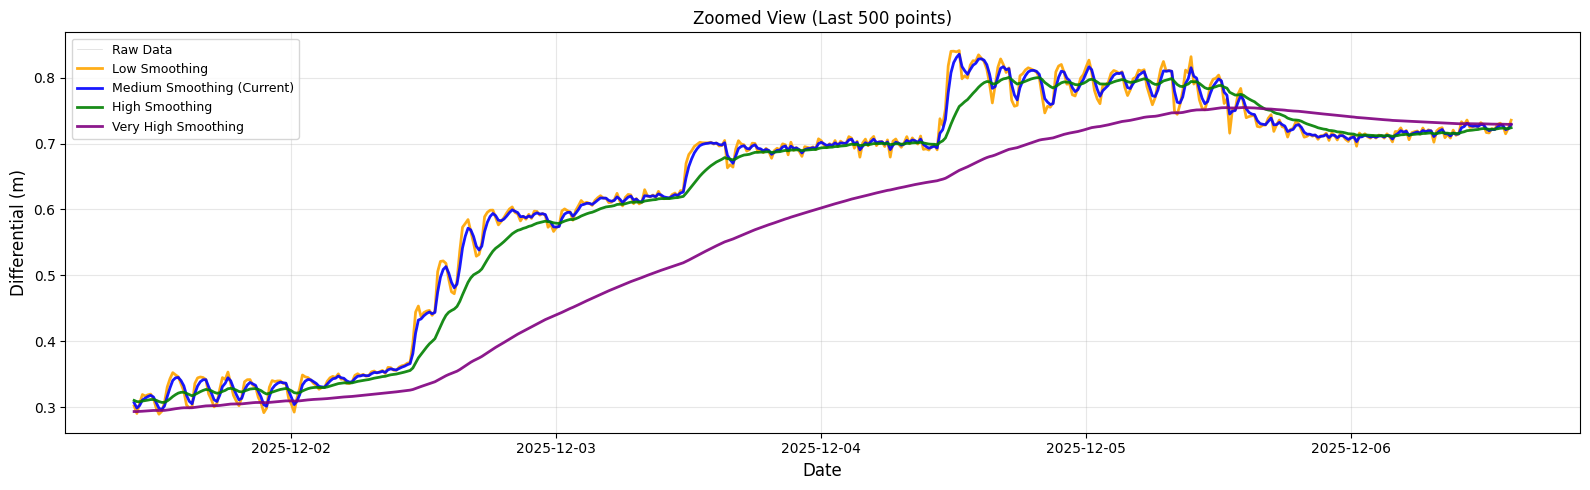


Tip: Adjust PROCESS_NOISE and MEASUREMENT_NOISE_FACTOR in Cell 5 to get your desired smoothing level!


In [49]:
# Visualize different smoothing levels for Godstow differential
# Plot 1: All smoothing levels
fig1, ax1 = plt.subplots(1, 1, figsize=(16, 5))

ax1.plot(godstow_filtered_df.index, godstow_measurements, 
         alpha=0.3, label='Raw Data', linewidth=0.5, color='gray', zorder=0)

colors = {'Low Smoothing': 'orange', 
          'Medium Smoothing (Current)': 'blue',
          'High Smoothing': 'green',
          'Very High Smoothing': 'purple'}

for name, filtered_data in godstow_comparison.items():
    ax1.plot(godstow_filtered_df.index, filtered_data, 
             label=name, linewidth=1.5, color=colors.get(name, 'black'), alpha=0.8)

ax1.set_ylabel('Differential (m)', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_title('Godstow Differential: Comparison of Smoothing Levels', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Zoomed in view (last 500 points)
fig2, ax2 = plt.subplots(1, 1, figsize=(16, 5))

zoom_start = max(0, len(godstow_measurements) - 500)
ax2.plot(godstow_filtered_df.index[zoom_start:], godstow_measurements[zoom_start:], 
         alpha=0.3, label='Raw Data', linewidth=0.5, color='gray', zorder=0)

for name, filtered_data in godstow_comparison.items():
    ax2.plot(godstow_filtered_df.index[zoom_start:], filtered_data[zoom_start:], 
             label=name, linewidth=2, color=colors.get(name, 'black'), alpha=0.9)

ax2.set_ylabel('Differential (m)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_title('Zoomed View (Last 500 points)', fontsize=12)
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTip: Adjust PROCESS_NOISE and MEASUREMENT_NOISE_FACTOR in Cell 5 to get your desired smoothing level!")


# Understanding the Two Parameters: Measurement Noise (R) vs Process Noise (Q)

## The Key Difference

### **Measurement Noise (R)** - "How noisy are my observations?"
- **Represents**: Uncertainty in the **measurements you receive**
- **Controls**: How much the filter **trusts each new measurement**
- **Real-world meaning**: Sensor accuracy, reading errors, measurement noise
- **Effect on filtering**: 
  - **High R** → Filter thinks measurements are unreliable → **MORE smoothing** (ignores noisy readings)
  - **Low R** → Filter thinks measurements are accurate → **LESS smoothing** (follows measurements closely)

### **Process Noise (Q)** - "How quickly can the true value change?"
- **Represents**: Uncertainty in **how the true state evolves over time**
- **Controls**: How much the filter allows the estimate to **change between time steps**
- **Real-world meaning**: Natural variability, how fast the underlying process can change
- **Effect on filtering**:
  - **Low Q** → Filter thinks state is very stable → **MORE smoothing** (resists change)
  - **High Q** → Filter thinks state can change quickly → **LESS smoothing** (adapts faster)

## Intuitive Example

Imagine you're tracking a car's position:

- **High Measurement Noise (R)**: Your GPS readings are very noisy/unreliable
  - → You trust your previous estimate more → **More smoothing**
  
- **Low Process Noise (Q)**: You know cars can't teleport (position changes smoothly)
  - → You resist sudden jumps in your estimate → **More smoothing**

## How They Work Together

The Kalman Gain formula combines both: **K = P / (P + R)**

Where P (covariance/uncertainty) is affected by Q:
- Low Q → P stays small → K stays small → More smoothing
- High R → K becomes small → More smoothing

**Both can create smoothing, but through different mechanisms:**
- **R** makes the filter trust measurements less
- **Q** makes the filter assume stability


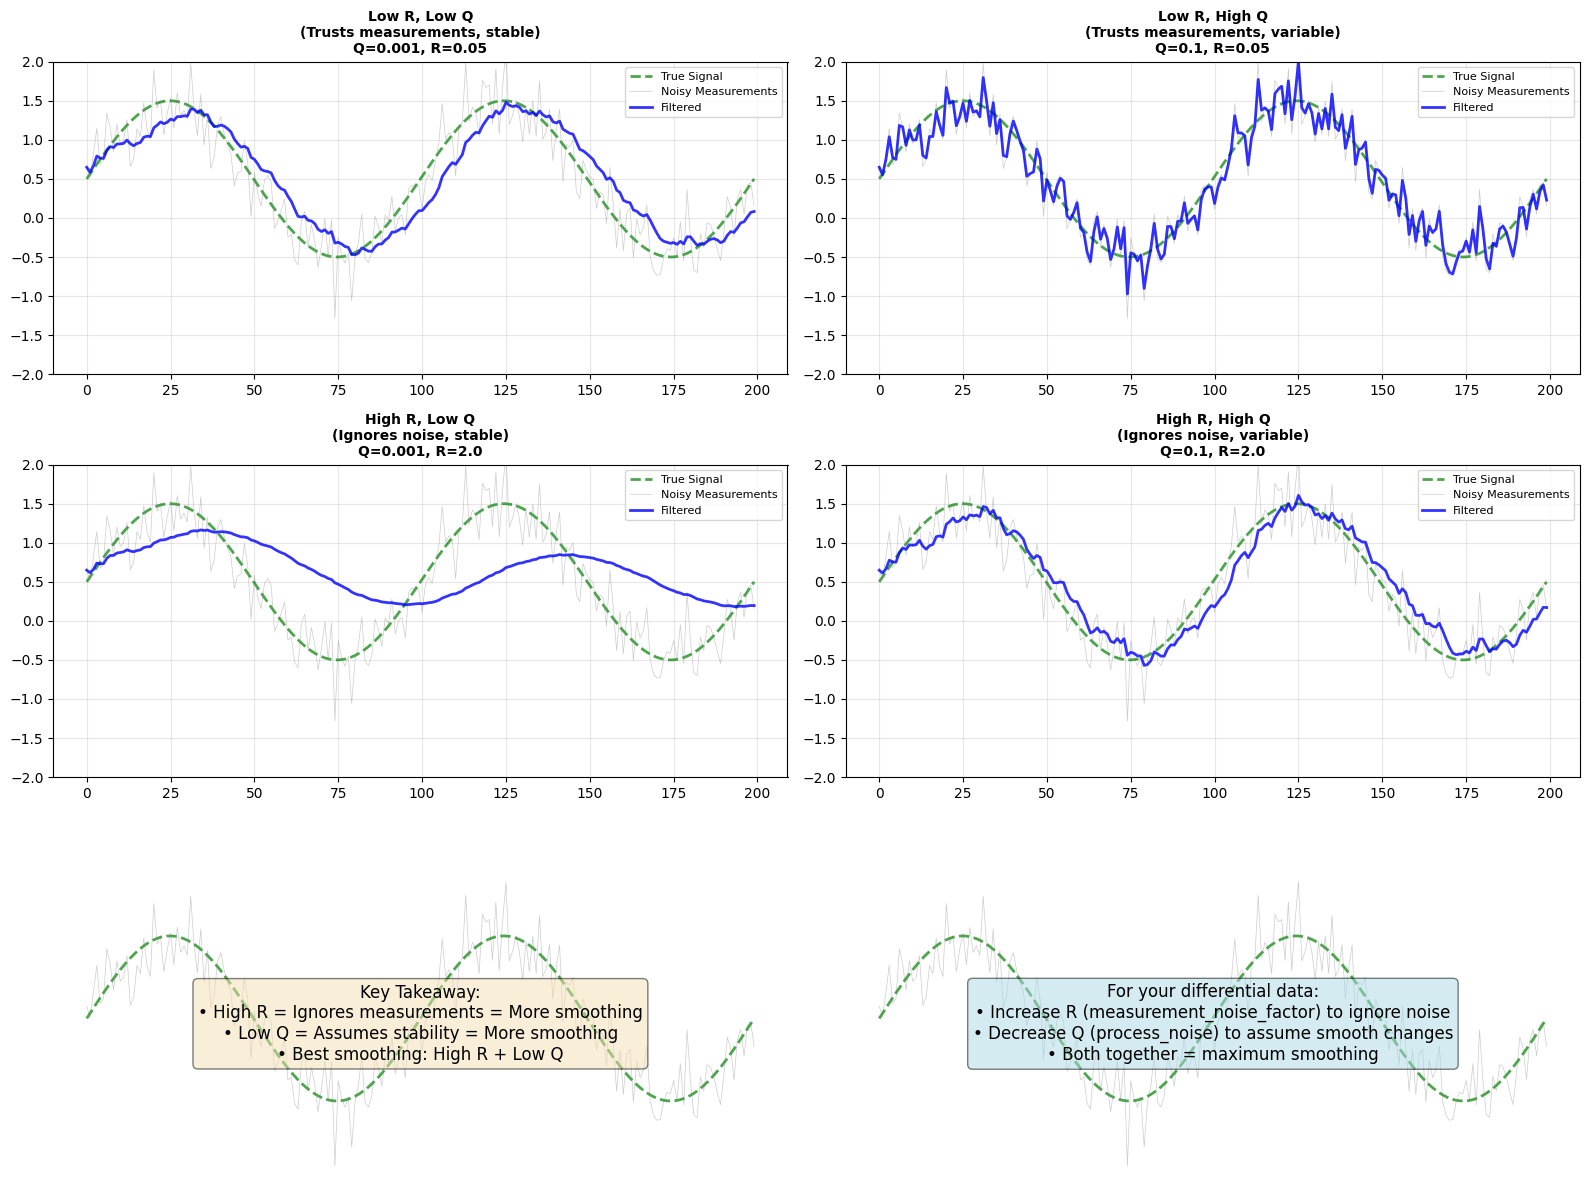


Summary:
• Measurement Noise (R) controls: 'Do I trust this measurement?'
• Process Noise (Q) controls: 'How much can the true value change?'
• Both affect smoothing, but R directly, Q indirectly through uncertainty


In [15]:
# Visual demonstration: How R and Q affect smoothing differently

# Create a simple test signal with noise
np.random.seed(42)
true_signal = np.sin(np.linspace(0, 4*np.pi, 200)) + 0.5
noisy_signal = true_signal + np.random.normal(0, 0.3, 200)

# Test different combinations
test_configs = {
    'Low R, Low Q\n(Trusts measurements, stable)': {'Q': 0.001, 'R': 0.05},
    'Low R, High Q\n(Trusts measurements, variable)': {'Q': 0.1, 'R': 0.05},
    'High R, Low Q\n(Ignores noise, stable)': {'Q': 0.001, 'R': 2.0},
    'High R, High Q\n(Ignores noise, variable)': {'Q': 0.1, 'R': 2.0},
}

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Plot true signal
for ax in axes.flatten():
    ax.plot(true_signal, 'g--', linewidth=2, label='True Signal', alpha=0.7)
    ax.plot(noisy_signal, 'gray', linewidth=0.5, label='Noisy Measurements', alpha=0.4)

# Test each configuration
for idx, (name, config) in enumerate(test_configs.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Apply filter
    kf_test = SimpleKalmanFilter(
        initial_state=noisy_signal[0],
        initial_covariance=1.0,
        process_noise=config['Q'],
        measurement_noise=config['R']
    )
    filtered_test, _ = kf_test.filter(noisy_signal)
    
    # Plot
    ax.plot(filtered_test, 'b-', linewidth=2, label='Filtered', alpha=0.8)
    ax.set_title(f'{name}\nQ={config["Q"]}, R={config["R"]}', fontsize=10, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-2, 2)

# Add summary axes
axes[2, 0].text(0.5, 0.5, 'Key Takeaway:\n• High R = Ignores measurements = More smoothing\n• Low Q = Assumes stability = More smoothing\n• Best smoothing: High R + Low Q', 
                ha='center', va='center', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                transform=axes[2, 0].transAxes)
axes[2, 0].axis('off')

axes[2, 1].text(0.5, 0.5, 'For your differential data:\n• Increase R (measurement_noise_factor) to ignore noise\n• Decrease Q (process_noise) to assume smooth changes\n• Both together = maximum smoothing', 
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
                transform=axes[2, 1].transAxes)
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

print("\nSummary:")
print("• Measurement Noise (R) controls: 'Do I trust this measurement?'")
print("• Process Noise (Q) controls: 'How much can the true value change?'")
print("• Both affect smoothing, but R directly, Q indirectly through uncertainty")


In [35]:
# Adaptive Kalman Filter - Ignores noise but responds to big changes and trends
class AdaptiveKalmanFilter:
    """
    Adaptive Kalman Filter that:
    1. Ignores small noise (high smoothing for small changes)
    2. Responds quickly to large changes (trusts measurements when change is significant)
    3. Follows slow background trends (allows gradual changes)
    """
    
    def __init__(self, initial_state=0.0, initial_covariance=1.0, 
                 base_process_noise=0.001, base_measurement_noise=0.1,
                 innovation_threshold=2.0, trend_window=20):
        """
        Initialize the adaptive Kalman filter.
        
        Parameters:
        -----------
        initial_state : float
            Initial estimate of the state
        initial_covariance : float
            Initial uncertainty
        base_process_noise : float
            Base process noise (low for smoothness)
        base_measurement_noise : float
            Base measurement noise (high to ignore noise)
        innovation_threshold : float
            Number of standard deviations to consider a "big change"
            Larger values = only respond to very large changes
        trend_window : int
            Number of recent points to use for trend detection
        """
        self.x = initial_state
        self.P = initial_covariance
        self.base_Q = base_process_noise
        self.base_R = base_measurement_noise
        self.innovation_threshold = innovation_threshold
        self.trend_window = trend_window
        
        # Adaptive parameters
        self.current_R = base_measurement_noise
        self.current_Q = base_process_noise
        
        # History for trend detection
        self.state_history = []
        self.measurement_history = []
        self.innovation_history = []
        self.adaptive_R_history = []
        
    def detect_trend(self, recent_states, window=None):
        """Detect if there's a slow background trend."""
        if window is None:
            window = self.trend_window
        if len(recent_states) < window:
            return 0.0
        
        # Use linear regression on recent states
        recent = recent_states[-window:]
        x = np.arange(len(recent))
        if len(recent) > 1:
            trend = np.polyfit(x, recent, 1)[0]  # Slope
            return trend
        return 0.0
    
    def predict(self, trend_estimate=0.0):
        """Predict step with optional trend component."""
        # Allow small trend-based change
        self.x += trend_estimate * 0.1  # Scale down trend influence
        self.P += self.current_Q
        return self.x, self.P
    
    def update(self, measurement):
        """
        Adaptive update step that adjusts measurement noise based on innovation.
        """
        self.measurement_history.append(measurement)
        
        # Calculate innovation (difference between measurement and prediction)
        innovation = measurement - self.x
        
        # Store innovation
        self.innovation_history.append(innovation)
        
        # Calculate innovation standard deviation (for normalization)
        if len(self.innovation_history) > 10:
            innovation_std = np.std(self.innovation_history[-20:])  # Use recent innovations
        else:
            innovation_std = self.base_R  # Fallback
        
        # Normalized innovation (in standard deviations)
        if innovation_std > 0:
            normalized_innovation = abs(innovation) / (innovation_std + 1e-10)
        else:
            normalized_innovation = 0.0
        
        # Adaptive measurement noise:
        # - Small innovation (likely noise) → High R (ignore it)
        # - Large innovation (likely real change) → Low R (respond quickly)
        if normalized_innovation > self.innovation_threshold:
            # Big change detected - trust measurement more (lower R)
            # Scale R down proportionally to innovation size
            reduction_factor = min(0.1, 1.0 / (normalized_innovation / self.innovation_threshold))
            self.current_R = self.base_R * reduction_factor
        else:
            # Small change - treat as noise (higher R)
            # Scale R up to smooth more
            self.current_R = self.base_R * (1.0 + (1.0 - normalized_innovation / self.innovation_threshold) * 2.0)
        
        self.adaptive_R_history.append(self.current_R)
        
        # Detect trend from recent state history
        if len(self.state_history) >= 2:
            trend = self.detect_trend(self.state_history)
        else:
            trend = 0.0
        
        # Prediction step (with trend)
        self.predict(trend_estimate=trend)
        
        # Calculate Kalman gain
        K = self.P / (self.P + self.current_R)
        
        # Update state estimate
        self.x = self.x + K * innovation
        
        # Update covariance
        self.P = (1 - K) * self.P
        
        # Store history
        self.state_history.append(self.x)
        
        return self.x, self.P
    
    def filter(self, measurements):
        """Apply adaptive filter to sequence of measurements."""
        filtered = []
        covariances = []
        
        for measurement in measurements:
            state, cov = self.update(measurement)
            filtered.append(state)
            covariances.append(cov)
        
        return np.array(filtered), np.array(covariances)
    
    def reset(self, initial_state=None, initial_covariance=None):
        """Reset filter."""
        if initial_state is not None:
            self.x = initial_state
        if initial_covariance is not None:
            self.P = initial_covariance
        
        self.state_history = []
        self.measurement_history = []
        self.innovation_history = []
        self.adaptive_R_history = []
        self.current_R = self.base_R
        self.current_Q = self.base_Q

print("✓ Adaptive Kalman Filter class defined")

✓ Adaptive Kalman Filter class defined


In [36]:
# ============================================================================
# ADAPTIVE KALMAN FILTER PARAMETERS
# ============================================================================
# This filter automatically adjusts to:
# - Ignore small noise (high smoothing)
# - Respond to big changes quickly
# - Follow slow background trends
# ============================================================================

# Base noise parameters (for noise rejection)
BASE_PROCESS_NOISE = 0.001      # Low = assumes smooth changes
BASE_MEASUREMENT_NOISE = 0.5    # Higher = ignores more noise

# Adaptive parameters
INNOVATION_THRESHOLD = 2.0       # How many std devs = "big change"? (try 1.5-3.0)
                                 # Lower = more sensitive to changes
TREND_WINDOW = 20                # Points to use for trend detection (try 10-50)

print("Applying Adaptive Kalman filters...\n")
print(f"Filter Parameters:")
print(f"  Base Process Noise (Q): {BASE_PROCESS_NOISE}")
print(f"  Base Measurement Noise (R): {BASE_MEASUREMENT_NOISE}")
print(f"  Innovation Threshold: {INNOVATION_THRESHOLD} std devs")
print(f"  Trend Window: {TREND_WINDOW} points")
print()

# Initialize adaptive filters
isis_adaptive_kf = AdaptiveKalmanFilter(
    initial_state=isis_measurements[0] if len(isis_measurements) > 0 else 0.0,
    initial_covariance=1.0,
    base_process_noise=BASE_PROCESS_NOISE,
    base_measurement_noise=BASE_MEASUREMENT_NOISE,
    innovation_threshold=INNOVATION_THRESHOLD,
    trend_window=TREND_WINDOW
)

godstow_adaptive_kf = AdaptiveKalmanFilter(
    initial_state=godstow_measurements[0] if len(godstow_measurements) > 0 else 0.0,
    initial_covariance=1.0,
    base_process_noise=BASE_PROCESS_NOISE,
    base_measurement_noise=BASE_MEASUREMENT_NOISE,
    innovation_threshold=INNOVATION_THRESHOLD,
    trend_window=TREND_WINDOW
)

# Apply filters
isis_adaptive_filtered, isis_adaptive_cov = isis_adaptive_kf.filter(isis_measurements)
godstow_adaptive_filtered, godstow_adaptive_cov = godstow_adaptive_kf.filter(godstow_measurements)

# Create DataFrames with filtered results
isis_adaptive_df = pd.DataFrame({
    'raw_differential': isis_measurements,
    'filtered_differential': isis_adaptive_filtered,
    'adaptive_R': isis_adaptive_kf.adaptive_R_history,
    'uncertainty': np.sqrt(isis_adaptive_cov)
}, index=isis_api_diff_df_clean.index)

godstow_adaptive_df = pd.DataFrame({
    'raw_differential': godstow_measurements,
    'filtered_differential': godstow_adaptive_filtered,
    'adaptive_R': godstow_adaptive_kf.adaptive_R_history,
    'uncertainty': np.sqrt(godstow_adaptive_cov)
}, index=godstow_api_diff_df_clean.index)

print("✓ Adaptive Kalman filtering complete")
print(f"\nISIS Adaptive Filter Results:")
print(f"  Mean raw differential: {isis_measurements.mean():.4f}")
print(f"  Mean filtered differential: {isis_adaptive_filtered.mean():.4f}")
print(f"  Mean adaptive R: {np.mean(isis_adaptive_kf.adaptive_R_history):.4f}")

print(f"\nGodstow Adaptive Filter Results:")
print(f"  Mean raw differential: {godstow_measurements.mean():.4f}")
print(f"  Mean filtered differential: {godstow_adaptive_filtered.mean():.4f}")
print(f"  Mean adaptive R: {np.mean(godstow_adaptive_kf.adaptive_R_history):.4f}")

Applying Adaptive Kalman filters...

Filter Parameters:
  Base Process Noise (Q): 0.001
  Base Measurement Noise (R): 0.5
  Innovation Threshold: 2.0 std devs
  Trend Window: 20 points

✓ Adaptive Kalman filtering complete

ISIS Adaptive Filter Results:
  Mean raw differential: 0.1562
  Mean filtered differential: 0.1543
  Mean adaptive R: 1.0006

Godstow Adaptive Filter Results:
  Mean raw differential: 0.3444
  Mean filtered differential: 0.3415
  Mean adaptive R: 0.9466


In [61]:
pip install ipympl


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


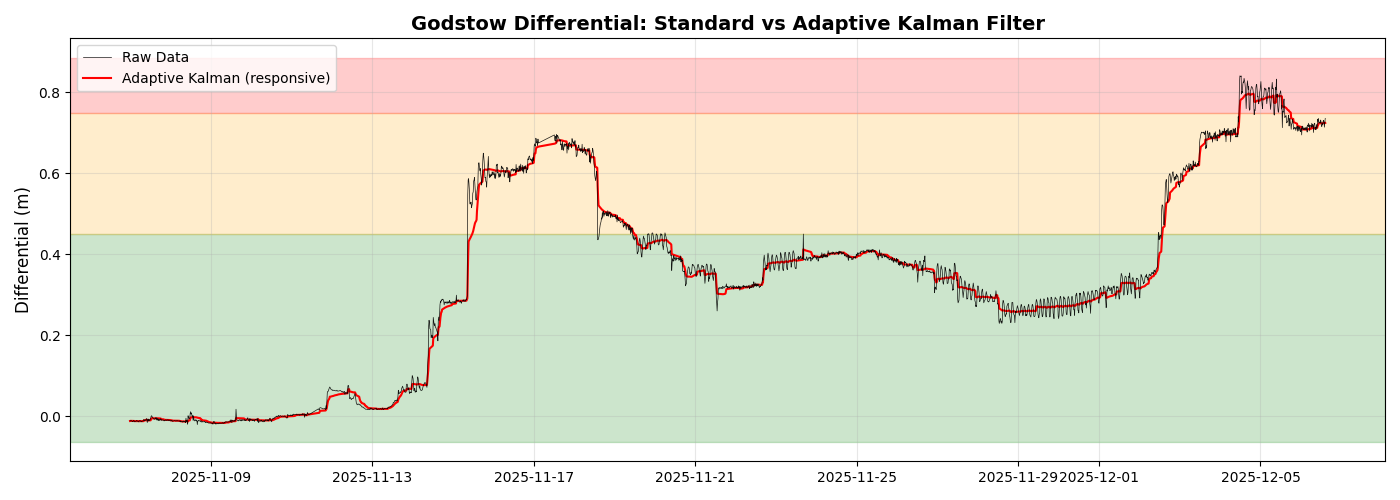


Key Insights:
• When adaptive R is LOW (green plot) → Filter is responding to big changes
• When adaptive R is HIGH (green plot) → Filter is smoothing/ignoring noise
• Innovation spikes (orange plot) → Big changes detected


In [62]:
%matplotlib widget
# Compare Adaptive vs Standard Kalman Filter
fig, axes = plt.subplots(1, 1, figsize=(14, 5), sharex=True)

# Plot 1: Raw vs Both Filters
axes.plot(godstow_filtered_df.index, godstow_measurements, 
             alpha=0.9, label='Raw Data', linewidth=0.5, color='black', zorder = 10)
axes.axhspan(ymin=axes.get_ylim()[0], ymax=0.45, color='green', alpha=0.2)
axes.axhspan(ymin=0.45, ymax=0.75, color='orange', alpha=0.2)
axes.axhspan(ymin=0.75, ymax=axes.get_ylim()[1], color='red', alpha=0.2)
axes.plot(godstow_adaptive_df.index, godstow_adaptive_filtered, 
             label='Adaptive Kalman (responsive)', linewidth=1.5, color='red')
axes.set_ylabel('Differential (m)', fontsize=12)
axes.set_title('Godstow Differential: Standard vs Adaptive Kalman Filter', fontsize=14, fontweight='bold')
axes.legend(loc='best')
axes.grid(True, alpha=0.3)

# Enable interactive zoom
from matplotlib.widgets import RectangleSelector
axes.format_coord = lambda x, y: f'Date: {pd.Timestamp.fromtimestamp(x/1e9).strftime("%Y-%m-%d %H:%M")}, Differential: {y:.3f}m'

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("• When adaptive R is LOW (green plot) → Filter is responding to big changes")
print("• When adaptive R is HIGH (green plot) → Filter is smoothing/ignoring noise")
print("• Innovation spikes (orange plot) → Big changes detected")